In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIRECTORY = os.path.join(os.getcwd(), 'data')
TRAIN_FILE_PATH = os.path.join(DATA_DIRECTORY, 'train.csv')
TEST_FILE_PATH = os.path.join(DATA_DIRECTORY, 'test.csv')

In [2]:
train = pd.read_csv(TRAIN_FILE_PATH)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


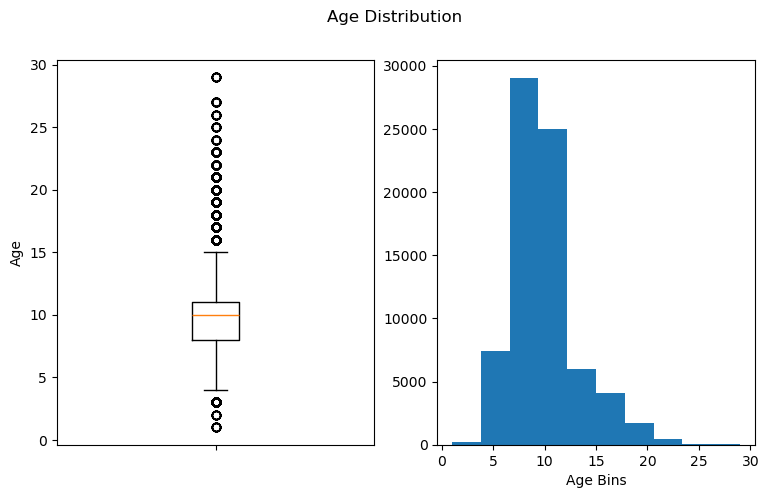

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

axes[0].boxplot(train['Age'], tick_labels=[''])
axes[0].set(ylabel='Age')

axes[1].hist(train['Age'], bins=10)
axes[1].set(xlabel='Age Bins', ylabel='')

fig.suptitle('Age Distribution')
plt.show()

In [4]:
train.groupby(by=['Sex'])[['Age', 'Diameter', 'Weight']].agg(['mean', 'median'])

Age         Diameter             Weight           
          mean median      mean  median       mean     median
Sex                                                          
F    11.341547   11.0  1.147902  1.1750  29.900418  29.965422
I     7.599073    7.0  0.798842  0.8125  11.653656  10.418441
M    10.895953   10.0  1.119254  1.1500  28.227125  28.207753

The `Intersex` crabs tend to be smaller, while `Female` and `Male` crabs are almost the same.

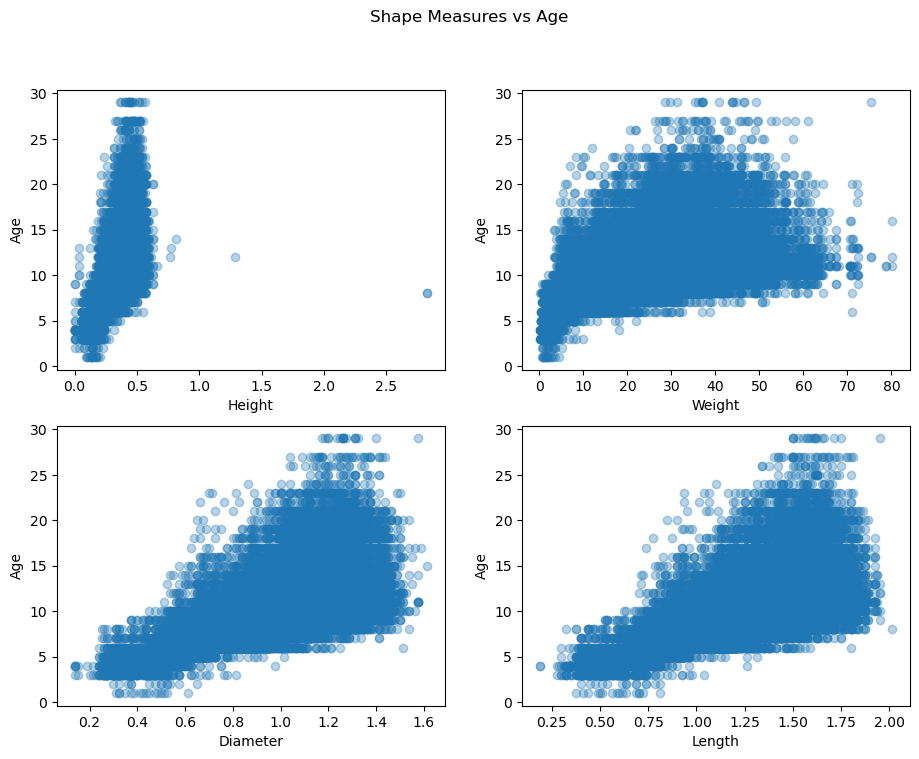

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))
for i, xy in enumerate(zip(['Height', 'Weight', 'Diameter', 'Length'], ['Age'] * 4)):
    x, y = xy
    ax = axes[i // 2, i % 2]
    ax.scatter(x=train[x], y=train[y], alpha=0.33)
    ax.set(xlabel=x, ylabel=y)

fig.suptitle('Shape Measures vs Age')
plt.show()

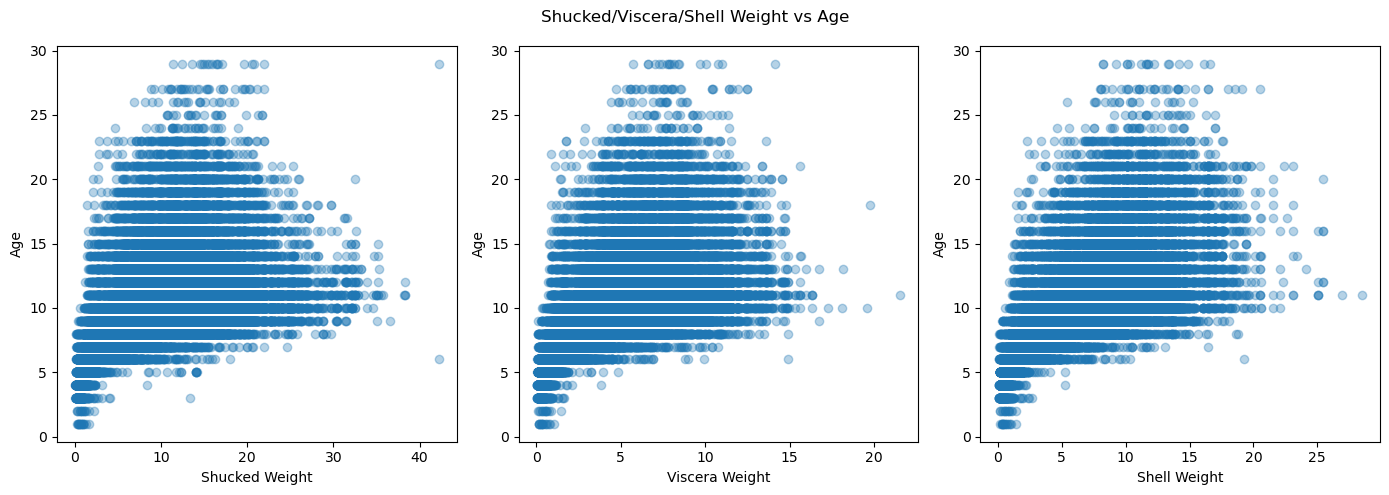

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))
for x, y, ax in zip(['Shucked Weight', 'Viscera Weight', 'Shell Weight'], ['Age'] * 3, axes):
    ax.scatter(x=train[x], y=train[y], alpha=0.33)
    ax.set(xlabel=x, ylabel=y)

fig.suptitle('Shucked/Viscera/Shell Weight vs Age')
plt.tight_layout()
plt.show()

There is a strong multicollinearity between `Weight` features, as well as between `Diameter` and `Length` -> this can be a problem for a regression model.  

Anyway, let's check the correlation coefficient between the independent variables and the dependent one, `Age`.

In [7]:
features_numeric = ['Length', 'Diameter', 'Height', 'Weight',
                    'Shucked Weight', 'Viscera Weight', 'Shell Weight']
y = train['Age']
corr_coefs = []
for col in features_numeric:
    corr_coef = np.corrcoef(train[col], y)[0, 1]
    corr_coefs.append((corr_coef, col))

corr_coefs.sort(reverse=True)
print('Correlation:')
for corr_coef, col in corr_coefs:
    print(f'{col}: {corr_coef:.3f}')

Correlation:
Shell Weight: 0.663
Height: 0.638
Diameter: 0.621
Length: 0.613
Weight: 0.601
Viscera Weight: 0.577
Shucked Weight: 0.503


We can see, that `Shell Weight`, `Height`, and `Diameter` can be selected out of the all independent features. However, they are likely to be correlated between each other.

In [8]:
# REPLACE ZEROs IN HEIGHT
min_height_not_0 = np.min(train.loc[train['Height'] > 0, 'Height'])
train.loc[train['Height'] == 0, 'Height'] = min_height_not_0

top3_corr_cols = ['Shell Weight', 'Height', 'Diameter']
train[top3_corr_cols].corr()

,Shell Weight,Height,Diameter
Shell Weight,1.000000,0.903472,0.922688
Height,0.903472,1.000000,0.921396
Diameter,0.922688,0.921396,1.000000


As you see, these columns are correlated a lot, so embedding them as they are to a regression may be a bad idea.  

Let's try some transformations.

In [47]:
from sklearn.base import TransformerMixin, BaseEstimator

class FrankensteinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transformations_ = {
            'Age': (np.sqrt, 'Age_sqrt'),
            'Height': (lambda arr: -np.log(arr), 'Height_-log'),
            'Shell Weight': (np.log, 'Shell Weight_log'),
            'Diameter': (np.log, 'Diameter_log'),
            'Length': (np.log, 'Length_log'),
            'Weight': (lambda arr: arr**0.3, 'Weight_**0.3'),
            'Viscera Weight': (np.log, 'Viscera Weight_log'),
            'Shucked Weight': (np.sqrt, 'Shucked Weight_sqrt')
        }
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        columns = X_.columns
        intersection = set(self.transformations_.keys()).intersection(set(columns))
        for col in list(intersection):
            transformer, new_column = self.transformations_[col]
            X_[new_column] = transformer(X_[col])
        if len(intersection): X_.drop(list(intersection), inplace=True, axis='columns')
        return X_
    
frankenstein_trnsf = FrankensteinTransformer()
frankenstein_train = frankenstein_trnsf.fit_transform(train[top3_corr_cols + ['Age', 'Sex']])

frankenstein_train.describe()

,Diameter_log,Age_sqrt,Height_-log,Shell Weight_log
count,74051.000000,74051.000000,74051.000000,74051.000000
mean,-0.010064,3.119330,1.098674,1.687224
std,0.281302,0.487431,0.318752,0.785110
min,-1.984131,1.000000,-1.038508,-3.157681
25%,-0.119347,2.828427,0.885519,1.378497
50%,0.072321,3.162278,1.014731,1.936069
75%,0.182322,3.316625,1.203973,2.205175
max,0.477786,5.385165,4.382027,3.349597


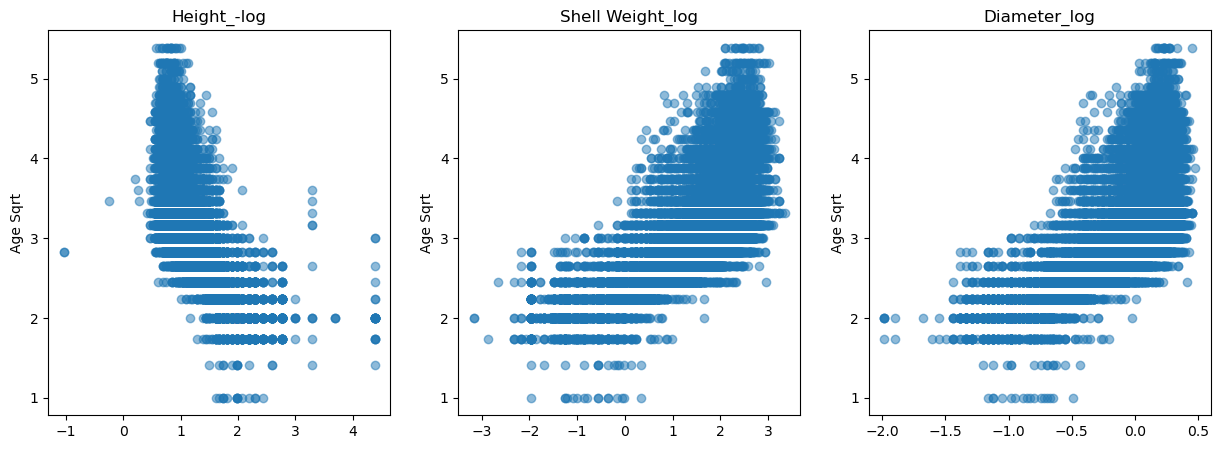

In [10]:
y = frankenstein_train['Age_sqrt']
features = ['Height_-log', 'Shell Weight_log', 'Diameter_log']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for feature, ax in zip(features, axes):
    ax.scatter(x=frankenstein_train[feature], y=y, alpha=0.5)
    ax.set(xlabel='', ylabel='Age Sqrt', title=feature)

plt.show()

In [11]:
def calc_corr_coeff(X, features, y):
    corr_coeffs = []
    for feature in features:
        corr_coef = np.corrcoef(X[feature], y)[0, 1]
        corr_coeffs.append((corr_coef, feature))
    corr_coeffs.sort(reverse=True)
    return corr_coeffs

calc_corr_coeff(X=frankenstein_train, features=features, y=y)

[(np.float64(0.7137748067667906), 'Shell Weight_log'),
 (np.float64(0.6734466376399199), 'Diameter_log'),
 (np.float64(-0.6832202566863471), 'Height_-log')]

The correlation coefficient increased a little bit, though it does not mean it can help a lot.  
Let's try to fit a simple `LinearRegression` and cross-validate it to see of how bad *(or good)* it performs.

In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error

def my_cv_predict_mae(estimator, X, y, cv=7, sqrt=True):
    fitted = cross_val_predict(estimator=estimator,
                               X=X, y=y, cv=cv)
    mae = mean_absolute_error(y**2, fitted**2) if sqrt else mean_absolute_error(y, fitted)
    #print(f'{mae:.2f}')
    return mae

output = 'Age_sqrt'
frank_male_crabs = frankenstein_train.loc[frankenstein_train['Sex'] == 'M', 
                                          features + [output]]

ridge = Ridge(alpha=1, solver='cholesky')
mae_trnsf = my_cv_predict_mae(estimator=ridge, X=frank_male_crabs[features], 
                              y=frank_male_crabs[output])
print(f'{mae_trnsf:.3f}')

1.772


Let's compare the `MAE` above to the `MAE` of the model trained on data with **no-transformation**.  
I want to do this just to check if I am doing the right steps at all.  

In [13]:
output_raw = 'Age'
features_raw = ['Shell Weight', 'Height', 'Diameter']
male_crabs = train.loc[frank_male_crabs.index, features_raw + [output_raw]]

mae_raw = my_cv_predict_mae(estimator=ridge,
                            X=male_crabs[features_raw], y=male_crabs[output_raw],
                            sqrt=False)
print(f'{mae_raw:.3f}')
print(f'Pct of Error Growth: {(mae_raw - mae_trnsf) / mae_trnsf*100:.2f}%')

1.828
Pct of Error Growth: 3.17%


Looks like it doesn't help a lot...  
Just for fun, let's perform a `two sample t-test` to check if this is a significant difference, though it seems to be a miserable one.

In [14]:
from scipy.stats import ttest_ind
def mae_for_ttest(estimator, X, y, cv=7, sqrt=True):
    fitted = cross_val_predict(estimator=estimator, 
                               X=X, y=y, cv=cv)
    return np.abs(y**2 - fitted**2 if sqrt else y - fitted)

mae_arr_trnsf = mae_for_ttest(estimator=ridge, X=frank_male_crabs[features],
                              y=frank_male_crabs[output])
mae_arr_raw = mae_for_ttest(estimator=ridge, X=male_crabs[features_raw],
                            y=male_crabs[output_raw], sqrt=False)

t_stat, p_val = ttest_ind(mae_arr_trnsf, mae_arr_raw, equal_var=False)
print(f'{p_val*100:.2f}%')

0.01%


Though, an increase/decrease in $0.05$ units of the error may seem ridiculous *(it is only ~3%)*, but it is statistically significant. However, it does not contribute to the model performance a lot.  
Our model is underfitting, thus we need to build a more complex one.  
One of the options may be to add `polynomial features`.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV

pipeline_frankie_ridge = Pipeline(steps=[
    ('frankenstein', FrankensteinTransformer()),
    ('std_scaling', StandardScaler()),
    ('polynomial', PolynomialFeatures()),
    ('ridge', Ridge(alpha=1, solver='cholesky')) 
])

param_grid = {
    'polynomial__degree': np.arange(2, 12)
}
gs_cv = GridSearchCV(estimator=pipeline_frankie_ridge, 
                    param_grid=param_grid,
                    scoring='neg_mean_absolute_error',
                    cv=5)

grid_result = gs_cv.fit(male_crabs[features_raw], 
                        np.sqrt(male_crabs[output_raw]))
print(grid_result.best_params_)

{'polynomial__degree': np.int64(3)}


In [16]:
best_poly_estimator = grid_result.best_estimator_
mae_poly = my_cv_predict_mae(estimator=best_poly_estimator,
                             X=male_crabs[features_raw],
                             y=np.sqrt(male_crabs[output_raw]))
print(f'{mae_poly:.3f}')
print(f'Pct of MAE growth: {(mae_poly - mae_trnsf)/mae_trnsf*100:.2f}%')

1.756
Pct of MAE growth: -0.89%


We can definetely see that even with polynomial features and standard scaling it seems pretty difficult to decrease the absolute error, thus to establish a much better performance using `Linear` models.  
However, we decreased the number of features significantly. `Ridge` linear models may lose a lot from such a decrease. We may come back to the linear model, but a little bit later.

### Ensemble Models

Let's try some of the ensemble models, starting with `RandomForestClassifier`. A very useful quality of this classifier is that it has `feature_importances` which can be useful in selecting features.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

rf_trnsf = ColumnTransformer(transformers=[
    ('std_scaler', StandardScaler(), features_numeric),
    ('one_hot', OneHotEncoder(), ['Sex'])
])
rf_pipeline = Pipeline(steps=[
    ('transformers', rf_trnsf),
    ('regressor', RandomForestRegressor(max_depth=5, random_state=42))
])

mae_rf = my_cv_predict_mae(estimator=rf_pipeline, 
                           X=train[features_numeric + ['Sex']],
                           y=train['Age'],
                           cv=5, sqrt=False)
print(f'{mae_rf:.3f}')

1.480


In [18]:
rf_pipeline.fit(X=train[features_numeric + ['Sex']], 
                y=train['Age'])

,steps,"[('transformers', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('std_scaler', ...), ('one_hot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
feature_names = rf_pipeline[:-1].get_feature_names_out()
feature_importances_raw = rf_pipeline.named_steps['regressor'].feature_importances_
feature_importances = [(score, name) for score, name in zip(feature_importances_raw, feature_names)]

feature_importances.sort(reverse=True)
feature_importances

[(np.float64(0.8687787762032884), 'std_scaler__Shell Weight'),
 (np.float64(0.09294488345465003), 'std_scaler__Shucked Weight'),
 (np.float64(0.030654618711833184), 'one_hot__Sex_I'),
 (np.float64(0.003260642698058468), 'std_scaler__Height'),
 (np.float64(0.003118404764925474), 'std_scaler__Weight'),
 (np.float64(0.0006437009110569983), 'std_scaler__Length'),
 (np.float64(0.00024160198823896086), 'std_scaler__Diameter'),
 (np.float64(0.0001681094601998674), 'one_hot__Sex_F'),
 (np.float64(0.00014666631754749264), 'std_scaler__Viscera Weight'),
 (np.float64(4.2595490201290165e-05), 'one_hot__Sex_M')]

Well, looks like `Shell Weight` is dominating the predictions. That may be an interesting observation...

However, let's try other models. Just for practice at first.

In [20]:
predictors_raw = features_numeric + ['Sex']

def top_k_indices(k, arr):
    indices = np.argpartition(arr, k)[-k:]
    return np.sort(indices)

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
        self.top_k_features = top_k_indices(k=self.k, arr=self.feature_importances)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[:, self.top_k_features]

#### Searching the Best Tree

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

dt_trnsf = ColumnTransformer(transformers=[
    ('std_scaler', StandardScaler(), features_numeric),
    ('one_hot', OneHotEncoder(), ['Sex'])
])
dt_pipeline = Pipeline(steps=[
    ('transformations', dt_trnsf),
    ('top_features', TopFeatureSelector(feature_importances=feature_importances_raw,
                                        k=5)),
    ('tree', DecisionTreeRegressor(random_state=42))
])

param_distributions = {
    'top_features__k': np.arange(2, len(features_numeric) + 3),
    'tree__max_depth': [3, 6, 9, 12, 15, 18],
    'tree__min_samples_split': [2, 10, 15, 20, 25, 50],
    'tree__min_weight_fraction_leaf': [0.0001, 0.001, 0.01, 0.1]
}
rs_best_tree = RandomizedSearchCV(estimator=dt_pipeline,
                                  param_distributions=param_distributions,
                                  n_iter=100,
                                  scoring='neg_mean_absolute_error',
                                  cv=3)

rs_best_tree.fit(X=train[predictors_raw], y=train[output_raw])
print(rs_best_tree.best_score_,
      rs_best_tree.best_params_)

-1.4406375065580825 {'tree__min_weight_fraction_leaf': 0.001, 'tree__min_samples_split': 10, 'tree__max_depth': 9, 'top_features__k': np.int64(6)}


In [23]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

adb_params = {
    'n_estimators': [150, 200, 250, 300, 350, 400],
    'learning_rate': [0.03, 0.06, 0.09, 0.12]
}
best_tree = rs_best_tree.best_estimator_.named_steps['tree']
preprocessing = rs_best_tree.best_estimator_[:-1]
rs_adaboost = RandomizedSearchCV(estimator=AdaBoostRegressor(best_tree),
                                 param_distributions=adb_params,
                                 n_jobs=-1,
                                 n_iter=18,
                                 scoring='neg_mean_absolute_error',
                                 cv=3)
# rs_adaboost.fit(X=preprocessing.fit_transform(train[predictors_raw]),
#                 y=train[output_raw])
# print(rs_adaboost.best_score_, rs_adaboost.best_params_)

In [52]:
from sklearn.model_selection import GridSearchCV
gs_params = {
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.0001, 0.0003]
}

gs_adaboost = GridSearchCV(estimator=AdaBoostRegressor(best_tree, random_state=42),
                           param_grid=gs_params,
                           n_jobs=-1,
                           scoring='neg_mean_absolute_error',
                           cv=3)
gs_adaboost.fit(X=preprocessing.fit_transform(train[predictors_raw]),
                y=train[output_raw])
print(gs_adaboost.best_score_, gs_adaboost.best_params_)

-1.411041424904627 {'learning_rate': 0.0001, 'n_estimators': 75}


As our best `Decision Tree` is pretty good, we can't have much more from `AdaBoostRegressor`. Let's try `GradientBoostingRegressor`.

In [ ]:
X = preprocessing.fit_transform(train[predictors_raw])
y = train[output_raw]
gbrt_params = {
    'learning_rate': [0.1, 0.3, 0.75],
    'max_depth': [2, 4, 6]
}
gbrt_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(n_estimators=150),
                                param_grid=gbrt_params,
                                scoring='neg_mean_absolute_error',
                                cv=3,
                                n_jobs=-1)
gbrt_grid_search.fit(X=X, y=y)
print(gbrt_grid_search.best_score_, gbrt_grid_search.best_params_)

-1.410300458783391 {'learning_rate': 0.1, 'max_depth': 4}


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(learning_rate=0.1, 
                                 max_depth=4,
                                 warm_start=True)
min_val_error = float('inf')
error_going_up = 0
for n_estimators in range (1, 250):
    gbrt.n_estimators_ = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    if mae < min_val_error: 
        min_val_error = mae
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5: break

maes = [mean_absolute_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

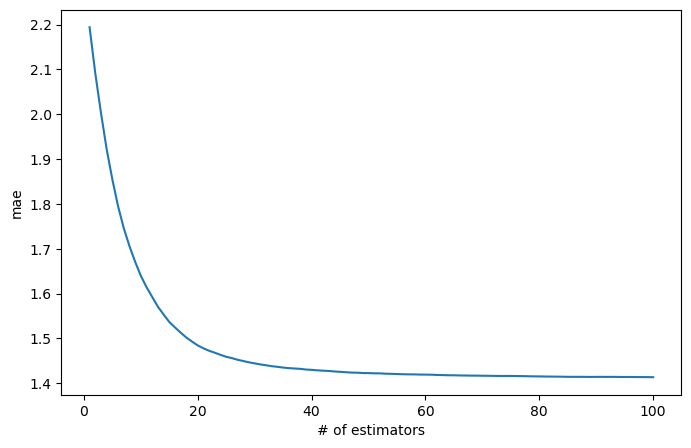

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(1, gbrt.n_estimators_), maes)
ax.set(xlabel='# of estimators', ylabel='mae')
plt.show()

### Ridge on Full Data

In [53]:
gs_adaboost

,estimator,AdaBoostRegre...ndom_state=42)
,param_grid,"{'learning_rate': [0.0001, 0.0003], 'n_estimators': [25, 50, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [55]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

gbrt_pipeline = Pipeline(steps=[
    ('transformations', dt_trnsf),
    ('top_features', TopFeatureSelector(feature_importances=feature_importances_raw,
                                        k=6)),
    ('tree', GradientBoostingRegressor(**gbrt.get_params()))
])

base = [
    ('rf', rf_pipeline),
    ('dt', dt_pipeline),
    # ('adaboost', gs_adaboost.best_estimator_),
    ('gbrt', gbrt_pipeline)
]
stacking_regressor = StackingRegressor(estimators=base,
                                       final_estimator=RidgeCV(),
                                       cv=5)
stacking_regressor.fit(X=train[predictors_raw], y=train[output_raw])

,estimators,"[('rf', ...), ('dt', ...), ...]"
,final_estimator,RidgeCV()
,cv,5
,n_jobs,None
,passthrough,False
,verbose,0
,transformers,"[('std_scaler', ...), ('one_hot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


In [56]:
mae_stacking_regressor = my_cv_predict_mae(estimator=stacking_regressor,
                                           X=train[predictors_raw],
                                           y=train[output_raw],
                                           sqrt=False)
print(f'{mae_stacking_regressor:.3f}')

1.408
